## Using Credit card customer dataset to predict attrition and cluster similar customers together
- The dataset consists of 10,000 customers mentioning their data such as age, salary, etc. 
- The dataset is obtained from https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers?select=BankChurners.csv

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA

### Introduction to dataset and analysis
#### The features in the dataset are as follows:
- Attrition_Flag: if the account is closed then 1 else 0
- Customer_Age: Customer's Age in Years
- Gender: M=Male, F=Female
- Dependent_count: Number of dependents
- Education_Level: Educational Qualification of the account holder
- Marital_Status: Married, Single, Divorced, Unknown
- Income_Category: Annual Income Category of the account holder
- Card_Category: Type of Card (Blue, Silver, Gold, Platinum)
- Months_on_book: Period of relationship with bank
- Total_Relationship_Count: Total no. of products held by the customer
- Months_Inactive_12_mon: No. of months inactive in the last 12 months
- Contacts_Count_12_mon: No. of Contacts in the last 12 months
- Credit_Limit: Credit Limit on the Credit Card
- Total_Revolving_Bal: Total Revolving Balance on the Credit Card
- Avg_Open_To_Buy: Open to Buy Credit Line (Average of last 12 months)
- Total_Amt_Chng_Q4_Q1: Change in Transaction Amount (Q4 over Q1)
- Total_Trans_Amt: Total Transaction Amount (Last 12 months)
- Total_Trans_Ct: Total Transaction Count (Last 12 months)
- Total_Ct_Chng_Q4_Q1: Change in Transaction Count (Q4 over Q1)
- Avg_Utilization_Ratio: Average Card Utilization Ratio

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

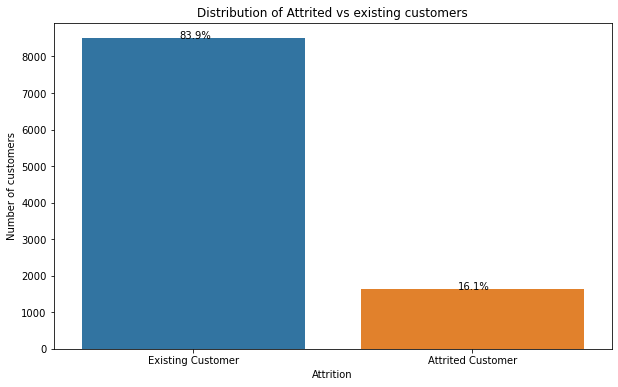

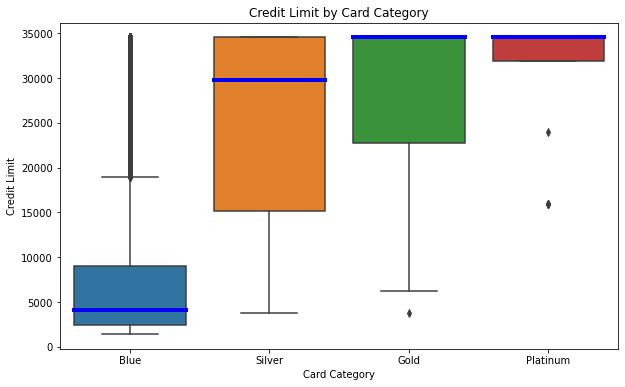

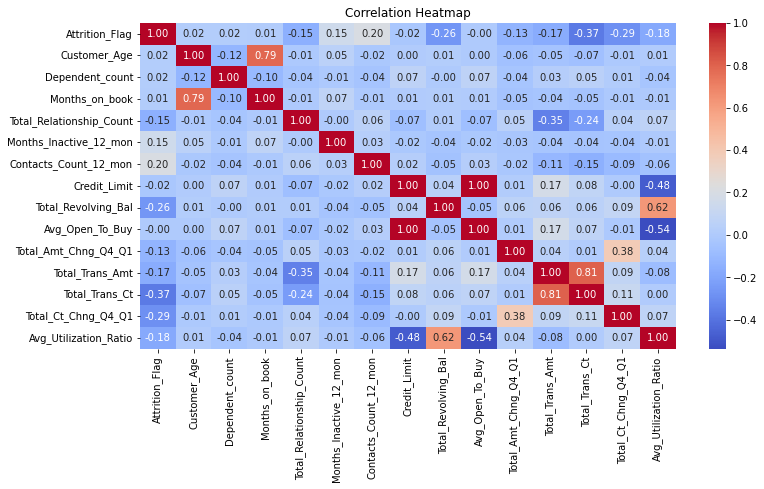

In [2]:
customer_data = pd.read_csv("C:/Users/vigne/Downloads/credit_card_customers/BankChurners.csv")

# We shall first remove the first column, ClientNum, as it is not useful for our analysis as well as the last 2 columns (as suggested by the dataset description on Kaggle)
customer_data = customer_data.drop(columns=['CLIENTNUM', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'])

# We shall now check for missing values in the dataset
print(customer_data.info())

# Display summary statistics for numerical columns
print(customer_data.describe())

#Visualise distribution of target variable - attrition_flag (to see whether the dataset is balanced or not)
plt.figure(figsize=(10, 6))
ax = sns.countplot(data = customer_data, x = "Attrition_Flag")
plt.title("Distribution of Attrited vs existing customers")
plt.xlabel("Attrition")
plt.ylabel("Number of customers")

# Calculate percentage of attrited and existing customers
for p in ax.patches:
    percentage = 100 * (p.get_height() / len(customer_data))
    ax.annotate(f'{percentage:.1f}%', (p.get_x() + 0.35, p.get_height() + 0.1))
plt.show()

# Boxplot to examine relationship between credit limit and card category to see if card category is an ordinal value (median is shown in blue)
plt.figure(figsize=(10, 6))
sns.boxplot(data=customer_data, x="Card_Category", y="Credit_Limit", order=['Blue', 'Silver', 'Gold', 'Platinum'], medianprops={'color': 'blue', 'linewidth': 4})
plt.title("Credit Limit by Card Category")
plt.xlabel("Card Category")
plt.ylabel("Credit Limit")
plt.show()

#Convert attrition flag to binary values
customer_data['Attrition_Flag'] = customer_data['Attrition_Flag'].map({'Existing Customer': 0, 'Attrited Customer': 1})

#Correlation heatmap for numerical features - to see which features are correlated with each other
plt.figure(figsize=(12, 6))
sns.heatmap(customer_data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()



### Data pre-processing and cleaning
- From above visualisation, we can see that there is no pair of features that are highly correlated (>0.9) and we cannot determine correlation with target variable so we shall keep all features for modelling.
- From above visualisation, card category somewhat determines credit limit and there seems to be distinction between card categories i.e., card categories can be ordered so we shall use ordinal encoder.
- Remove 'Unknown' values
- Convert categorical variables to numerical variables

In [3]:
# Convert categorical columns to numerical values, starting with gender
label_encoder = LabelEncoder()
customer_data['Gender'] = label_encoder.fit_transform(customer_data['Gender'])

# Display the unique values in each categorical column
print(f"Education level values: {customer_data['Education_Level'].unique()}")
print(f"Income category values: {customer_data['Income_Category'].unique()}")
print(f"Card category values: {customer_data['Card_Category'].unique()}")
print(f"Marital status values: {customer_data['Marital_Status'].unique()}")

# Remove rows with 'Unknown' values in the Education_Level, Income_Category and Marital_Status columns
print(f"Number of entries before removing unknown values: {customer_data.shape[0]}")
customer_data = customer_data[customer_data['Education_Level'] != 'Unknown']
customer_data = customer_data[customer_data['Income_Category'] != 'Unknown']
customer_data = customer_data[customer_data['Marital_Status'] != 'Unknown']
print(f"Number of entries after removing unknown values: {customer_data.shape[0]}")

#Use ordinal encoding to encode education level, income category and card category
education_order = ['Uneducated', 'High School', 'College', 'Graduate' , 'Post-Graduate', 'Doctorate']
income_order = ['Less than $40K', '$40K - $60K', '$60K - $80K', '$80K - $120K', '$120K +']
card_order = ['Blue', 'Silver', 'Gold', 'Platinum']

ordinal_encoder = OrdinalEncoder(categories=[education_order, income_order, card_order])
ordinal_encoded = ordinal_encoder.fit_transform(customer_data[['Education_Level', 'Income_Category', 'Card_Category']])
customer_data[['Education_Level', 'Income_Category', 'Card_Category']] = ordinal_encoded

#Use one hot encoding to encode marital status
one_hot_encoder = OneHotEncoder()
one_hot_encoded = one_hot_encoder.fit_transform(customer_data[['Marital_Status']]).toarray()

feature_names = one_hot_encoder.get_feature_names_out(['Marital_Status'])
one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=feature_names, index = customer_data.index)
customer_data = pd.concat([customer_data, one_hot_encoded_df], axis=1)

# Drop the original Marital_Status column
customer_data.drop(columns=['Marital_Status'], inplace=True)

print(customer_data.head())


Education level values: ['High School' 'Graduate' 'Uneducated' 'Unknown' 'College' 'Post-Graduate'
 'Doctorate']
Income category values: ['$60K - $80K' 'Less than $40K' '$80K - $120K' '$40K - $60K' '$120K +'
 'Unknown']
Card category values: ['Blue' 'Gold' 'Silver' 'Platinum']
Marital status values: ['Married' 'Single' 'Unknown' 'Divorced']
Number of entries before removing unknown values: 10127
Number of entries after removing unknown values: 7081
   Attrition_Flag  Customer_Age  Gender  Dependent_count  Education_Level  \
0               0            45       1                3              1.0   
1               0            49       0                5              3.0   
2               0            51       1                3              3.0   
4               0            40       1                3              0.0   
5               0            44       1                2              3.0   

   Income_Category  Card_Category  Months_on_book  Total_Relationship_Count  \
0    

## Supervised learning
- We will be using logistic regression, random forest and Support Vector Machine (SVM) to perform binary classification on the Attrition_Flag column.

- The purpose of these models are to predict whether each customer is likely to leave the credit card service based on their recorded data.

- We will be scaling each feature using a StandardScaler to ensure all features are on the same scale. This prevents the SVM and logistic regression models from prioritizing features with larger scale ranges, ensuring that all features contribute equally.

- However, we will be using unscaled data for random forest as it is insensitive to scale of features.

- We shall also perform stratified sampling when using train_test_split as well as cross validation since target variable ("Attrition_Flag") is not balanced. We will also set class_weight = 'balanced' within the model parameters to account for imbalance.

- For cross-validation, we will use a stratified 4-fold validation and use the f1 score to maximise both precision and recall.


In [4]:
X = customer_data.drop(columns=['Attrition_Flag'])
y = customer_data['Attrition_Flag'] 

# Stratified split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 4)

# Feature scaling (only on numerical features)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Cross-validation
cv = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 4)


### Logistic Regression

-------------------------------------Logistic Regression Results-------------------------------------
Best Parameters for Logistic Regression:  {'C': 1}
Best Cross-Validation Score:  0.616381405277885
Logistic Regression Test F1 Score:  0.6088379705400981
Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.83      0.89      1194
           1       0.48      0.83      0.61       223

    accuracy                           0.83      1417
   macro avg       0.72      0.83      0.75      1417
weighted avg       0.89      0.83      0.85      1417



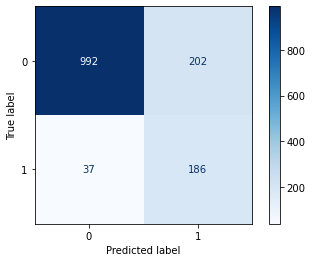

In [5]:
# Logistic Regression
logistic_params = {
    'C': [0.01, 0.1, 1],  # Regularization strength
}
logistic_model = LogisticRegression(class_weight = 'balanced', random_state = 4)
logistic_grid = GridSearchCV(estimator = logistic_model, param_grid = logistic_params, cv = cv, scoring = 'f1')
logistic_grid.fit(X_train_scaled, y_train)

# Best logistic model
best_logistic = logistic_grid.best_estimator_
y_pred_logistic = best_logistic.predict(X_test_scaled)
print("-------------------------------------Logistic Regression Results-------------------------------------")
print("Best Parameters for Logistic Regression: ", logistic_grid.best_params_)
print("Best Cross-Validation Score: ", logistic_grid.best_score_)
print("Logistic Regression Test F1 Score: ", f1_score(y_test, y_pred_logistic))
print("Classification Report: \n", classification_report(y_test, y_pred_logistic))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_logistic, cmap=plt.cm.Blues)

### Random Forest

-------------------------------------Random Forest Results-------------------------------------
Best Parameters for Random Forest:  {'max_depth': 20, 'min_samples_split': 8, 'n_estimators': 150}
Best Cross-Validation Score:  0.8331254214920032
Random Forest Test F1 Score:  0.875
Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.98      0.98      1194
           1       0.90      0.85      0.88       223

    accuracy                           0.96      1417
   macro avg       0.94      0.92      0.93      1417
weighted avg       0.96      0.96      0.96      1417



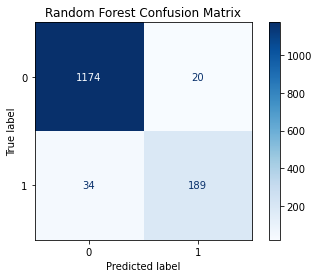

In [6]:
rf_params = {
    'n_estimators': [50, 100, 150],  # Number of trees
    'max_depth': [1, 10, 20],  # Depth of each tree
    'min_samples_split': [2, 5, 8]  # Minimum samples to split a node
}

# Random Forest cross validation
random_forest_model = RandomForestClassifier(class_weight = 'balanced', random_state = 4)
rf_grid = GridSearchCV(estimator=random_forest_model, param_grid=rf_params, cv=cv, scoring='f1')
rf_grid.fit(X_train, y_train)  # Random Forest does not need scaled data

# Best logistic model
best_rf = rf_grid.best_estimator_
y_pred_rf = best_rf.predict(X_test)

print("-------------------------------------Random Forest Results-------------------------------------")
print("Best Parameters for Random Forest: ", rf_grid.best_params_)
print("Best Cross-Validation Score: ", rf_grid.best_score_)
print("Random Forest Test F1 Score: ", f1_score(y_test, y_pred_rf))
print("Classification Report: \n", classification_report(y_test, y_pred_rf))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, cmap = plt.cm.Blues)
plt.title("Random Forest Confusion Matrix")
plt.show()


### Support Vector Machine (SVM)

-------------------------------------SVM Results-------------------------------------
Best Parameters for SVM:  {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best Cross-Validation Score:  0.7268712054577711
SVM Test F1 Score:  0.7436974789915967
Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.94      0.95      1194
           1       0.70      0.79      0.74       223

    accuracy                           0.91      1417
   macro avg       0.83      0.87      0.85      1417
weighted avg       0.92      0.91      0.92      1417



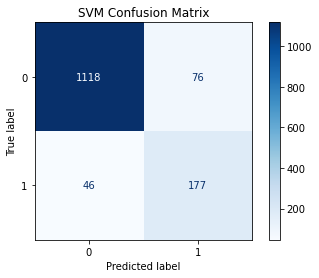

In [7]:
svm_params = {
    'C': [0.1, 1, 10],  # Regularization strength
    'kernel': ['rbf'], 
    'gamma': [1, 0.1, 0.01]  # Kernel coefficient for rbf
}

# SVM cross validation
svm_model = SVC(class_weight = 'balanced', random_state = 4)
svm_grid = GridSearchCV(estimator = svm_model, param_grid = svm_params, cv = cv, scoring = 'f1')
svm_grid.fit(X_train_scaled, y_train)

# Best SVM model
best_svm = svm_grid.best_estimator_
y_pred_svm = best_svm.predict(X_test_scaled)

print("-------------------------------------SVM Results-------------------------------------")
print("Best Parameters for SVM: ", svm_grid.best_params_)
print("Best Cross-Validation Score: ", svm_grid.best_score_)
print("SVM Test F1 Score: ", f1_score(y_test, y_pred_svm))
print("Classification Report: \n", classification_report(y_test, y_pred_svm))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm, cmap = plt.cm.Blues)
plt.title("SVM Confusion Matrix")
plt.show()

### Analysis of supervised learning results
- The random forest model seemed to perform the best with a high test f1 score of 0.875 followed by the SVM with a test f1 score of 0.74 and then logistic regression with a test f1 score of 0.61.

- The random forest model also outperformed others in precision and recall, balancing false positives and false negatives. This is likely due to the model's ensemble nature, which aggregates predictions over multiple trees to improve stability and accuracy.

- Random forest is able to capture complex, non-linear relationships in the data and is robust to outliers through the ensemble of decision trees.

- SVM managed to capture the non-linear relationships in the dataset but fell short when it comes to capturing feature importance, which the random forest excels at.

- Logistic regression, being a linear model, struggled to capture non-linear relationships in the dataset, leading to lower precision, recall, and overall F1 score.

## Unsupervised Learning
- For the unsupervised task, we shall do K-means clustering with and without Principal Component Analysis(PCA)
- Principal Component Analysis helps to reduce dimensionality of the dataset. 
- Currently, there are 22 features and PCA could help to reduce the number of variables while preserving as much information as possible

### Elbow method to determine value of K for K-means
- First, to determine the number of clusters to use, we shall employ the elbow method.
- The elbow method is a plot of the within cluster sum of squares(WCSS) against number of clusters.
- We will choose the number of clusters such that we minimise the WCSS while preventing overfitting.
- This optimal point occurs at the "elbow" where the rate of decrease of WCSS drops off. 

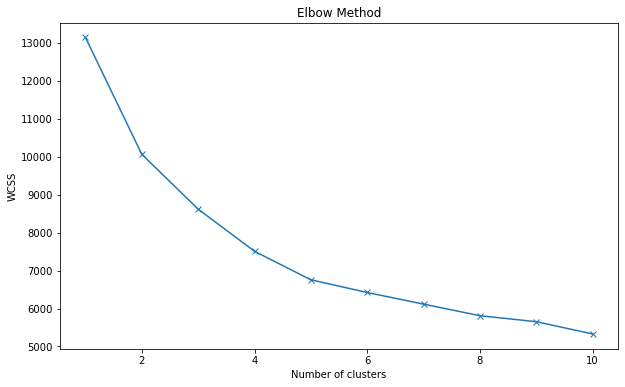

In [8]:
#Perform MinMax scaling on the entire dataset
scaler = MinMaxScaler()
customer_data_scaled = scaler.fit_transform(customer_data)
customer_data_scaled = pd.DataFrame(customer_data_scaled, columns = customer_data.columns)

#Elbow method

wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters = k, random_state = 4)
    kmeans.fit(customer_data_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='x')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### K-means clustering
- Based on the elbow method, to reduce within cluster sum of squares while preventing overfitting, we will choose to perform K-means on 4 clusters.

In [9]:
kmeans = KMeans(n_clusters = 4, random_state = 4)
initial_results = kmeans.fit_predict(customer_data_scaled)

#Evaluation of clustering
silhouette = silhouette_score(customer_data_scaled, initial_results)
print(f"Initial K-means Silhouette Score: {silhouette}")

davies_bouldin = davies_bouldin_score(customer_data_scaled, initial_results)
print(f'Initial K-means Davies Bouldin Score: {davies_bouldin}')

Initial K-means Silhouette Score: 0.23447934229287434
Initial K-means Davies Bouldin Score: 1.653681844778971


### K-means clustering after PCA
- Perform K-means clustering after principal component analysis.
- Reduce to 2 dimensions to retain most important information and visualise data

K-means after PCA Silhouette Score: 0.6835471963535509
K-means after PCA Davies Bouldin Score: 0.44497135617750005


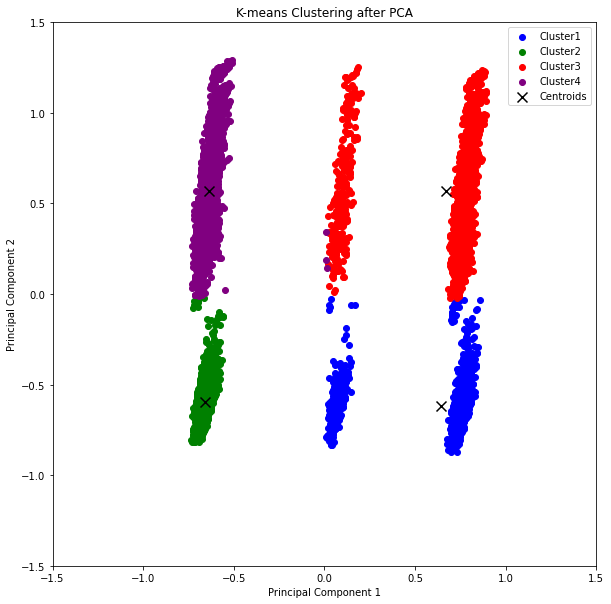

[0.24748385 0.21850697]
Total Explained Variance captured by PCA: 0.46599081728275854
Cluster means for all features: 
          Attrition_Flag  Customer_Age    Gender  Dependent_count  \
Cluster                                                            
0              0.176064     45.884925  0.017261         2.284235   
1              0.163302     46.966746  0.010689         2.336105   
2              0.156532     46.107545  1.000000         2.324324   
3              0.134891     46.447690  0.999469         2.401487   

         Education_Level  Income_Category  Card_Category  Months_on_book  \
Cluster                                                                    
0               2.056962         0.232451       0.061565       35.575949   
1               2.123515         0.235748       0.040974       36.454869   
2               2.047297         2.360923       0.131194       36.022523   
3               2.039830         2.399363       0.093999       35.893255   

         Total

In [10]:
# Apply PCA to reduce dimensionality
pca = PCA(n_components = 2)  # Reduce to 2 dimensions for visualization
customer_data_pca = pca.fit_transform(customer_data_scaled)

# Perform K-means clustering on the PCA-transformed data
kmeans_pca = KMeans(n_clusters = 4, random_state = 4)
pca_results = kmeans_pca.fit_predict(customer_data_pca)

# Evaluation of clustering
silhouette_pca = silhouette_score(customer_data_pca, pca_results)
print(f"K-means after PCA Silhouette Score: {silhouette_pca}")

davies_bouldin_pca = davies_bouldin_score(customer_data_pca, pca_results)
print(f'K-means after PCA Davies Bouldin Score: {davies_bouldin_pca}')

colours = ['blue', 'green', 'red', 'purple'] 

# Plot the clusters in 2 dimensions
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.scatter(customer_data_pca[pca_results == i, 0], customer_data_pca[pca_results == i, 1], c = colours[i], label = f'Cluster{i+1}')

plt.title('K-means Clustering after PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

# Add cluster centroids
centroids = kmeans_pca.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c = 'black', s = 100, marker = 'x', label = 'Centroids')
plt.legend()
plt.show()

print(pca.explained_variance_ratio_)
print(f"Total Explained Variance captured by PCA: {pca.explained_variance_ratio_.sum()}")

# Find cluster means for each feature
customer_data_copy = customer_data.copy()
customer_data_copy['Cluster'] = pca_results
cluster_means = customer_data_copy.groupby('Cluster').mean()

print(f"Cluster means for all features: \n {cluster_means}")

### Analysis of clustering

#### Evaluation metrics used
- To evaluate the clustering we will use Silhouette score and Davies-Bouldin score.

- The Silhouette score measures how similar a data point is to its own cluster compared to other clusters.

- The Davies-Bouldin score evaluates the average similarity ratio of intra-cluster distances to inter-cluster distances.

- A higher Silhouette score indicates better clustering while a lower Davies-Bouldin score is an indication of improved clustering.

- Using both Davies-Bouldin and Silhouette scores helps give a more complete picture of how good the clustering is, with one focusing on how well the clusters are separated and the other on how well each point fits in its own cluster.

#### Comparison between performing K-means clustering with and without PCA
- The initial K-means algorithm gives poor performance as indicated by the low Silhouette score and relatively high Davies-Bouldin score

- However we get much better scores after dimensionality reduction with PCA. This could be a result of PCA helping the clustering algorithm to find more meaningful patterns by retaining only the most important and relevant information. It helps to reduce noise and impact of irrelevant features.

#### PCA Clustering diagram
- Regardless of the higher Silhouette score, based on the diagram, the clusters do not appear distinct and separate from one another. The intra-cluster distance seem high while inter-cluster distance seems relatively low.

- Upon further exploring the variance captured by the PCA algorithm, we see that only 46.6% of the total variance is captured. This indicates that the PCA components might not have effectively spread the underlying data which could cause the poor clustering. 

- Furthermore, K-means assumes spherical clusters and linear separations might indicate that K-means is unsuitable for this datset. Going forward, other clustering algorithms should be tested such as DBSCAN which is more suitable for irregular shapes.